A bank marketing dataset from UCI Machine Learning Repository was adopted for this project (https://archive.ics.uci.edu/ml/datasets/bank+marketing(link is external)). The dataset is about a Portuguese banking institution with records of direct marketing campaign phone calls, and the final outcomes indicating whether success campaigns are also included in a binary format (yes/no). A success campaign indicates the customer has finally subscribed a term deposit at the end of the campaign. Our business goal here is to identify the elements for a success campaign, from which we can improve marketing effectiveness by targeting the right customers; that is, we want to find what kind of campaign strategies/history combined with what kinds of customers will bring about high propensities for subscribing term deposits. Via building predictive models outputting the propensities of subscribing, we can therefore increase revenues and lower labour costs by having more efficient marketing strategies without harming customer relationship

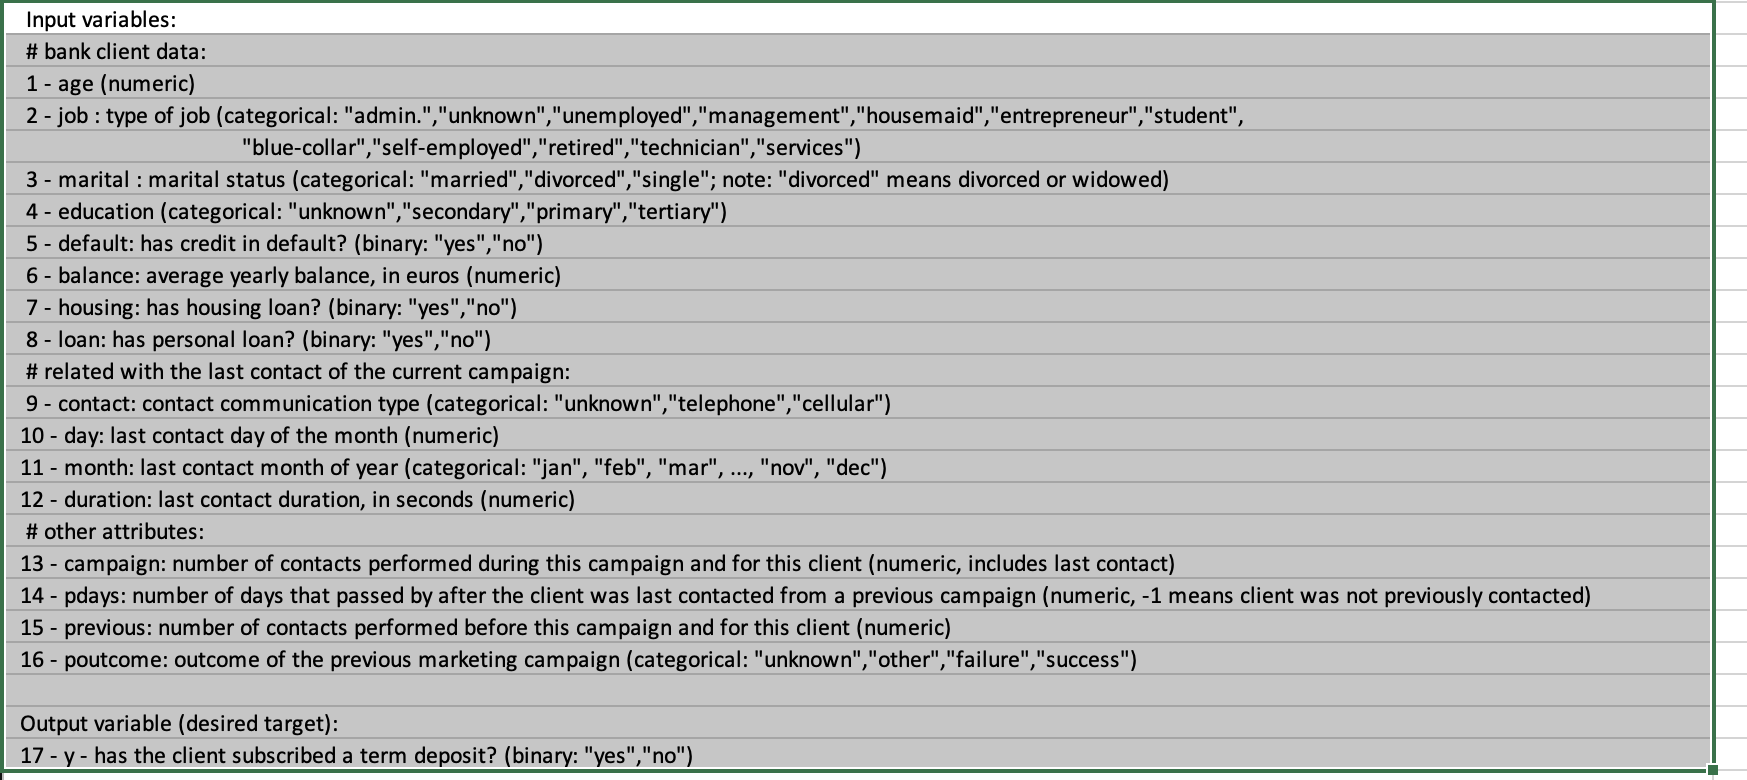

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
ls

'10 requests for 10 currencies.csv'
'10 requests for 10 currencies.gsheet'
 bank.csv
 Base10/
'Copy of IDS 561 - Group Project - Team 4.ipynb'
'Copy of IDS 561 - Group Project VER 2 - Team 4.ipynb'
 Crypto.ipynb
 fraud.csv
'healthcare analytics'/
 HW2PySparkAssignment.ipynb
 HW3_Pyspark.ipynb
 ilead/
 LoanDefaultProject.ipynb
 MLOPs/
 Nomics-Dashboard-USD-1d-2022-02-05T08_06_12.721Z.csv
 Nomics-Dashboard-USD-1d-2022-02-05T08_06_12.721Z.gsheet
 Number_Guessing_Game
 TermDeposit.ipynb
 test.csv
 test_v2.csv
 train_v2.csv


In [ ]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import chi2

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.simplefilter(action='ignore')

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df=pd.read_csv("bank.csv",sep=';')


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Removing some columns - 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous' and 'poutcome' (these columns describe a telephone call that has happened already, therefore they should not be used in our predictive model) - We are going to predict whether or not the customers are likely to opt for term deposit and we will take only those columns which are highly likely to be present in our database.

In [ ]:
df = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan', 'y']]
print(df.shape)
df.head()

(4521, 9)


,age,job,marital,education,default,balance,housing,loan,y
0,30,unemployed,married,primary,no,1787,no,no,no
1,33,services,married,secondary,no,4789,yes,yes,no
2,35,management,single,tertiary,no,1350,yes,no,no
3,30,management,married,tertiary,no,1476,yes,yes,no
4,59,blue-collar,married,secondary,no,0,yes,no,no


# Data Cleaning, Feature Selection, Feature Transformation

## Treat Unknown Values - Imputation

We see from the EDA section that there are unknown values in education and job. Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. **Our hypothesis here is that 'job' is influenced by the 'education' of a person**. Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

In [ ]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [ ]:
cross_tab(df,'job','education')

,primary,secondary,tertiary,unknown
job,,,,
admin.,17,393,51,17
blue-collar,369,524,12,41
entrepreneur,26,58,73,11
housemaid,57,28,22,5
management,39,116,787,27
retired,80,105,31,14
self-employed,15,76,88,4
services,25,363,16,13
student,2,47,19,16


In [ ]:
df['job'][df['age']>60].value_counts()

retired          93
management       12
housemaid         6
blue-collar       4
unknown           4
admin.            3
technician        2
self-employed     2
entrepreneur      1
Name: job, dtype: int64

In [ ]:
# if job unknowns are such that age > 60, we assume retired - 4 replacements
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
cross_tab(df,'job','education')

,primary,secondary,tertiary,unknown
job,,,,
admin.,17,393,51,17
blue-collar,369,524,12,41
entrepreneur,26,58,73,11
housemaid,57,28,22,5
management,39,116,787,27
retired,80,106,32,16
self-employed,15,76,88,4
services,25,363,16,13
student,2,47,19,16


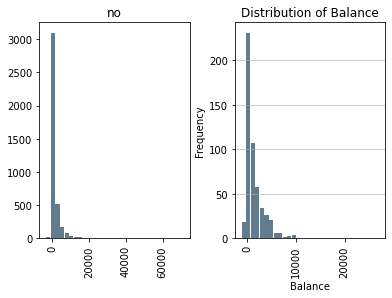

In [ ]:
size, scale = 1000, 10
df.hist(column='balance',grid=True, bins=30, rwidth=0.9, color='#607c8e',by = 'y')

plt.title('Distribution of Balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

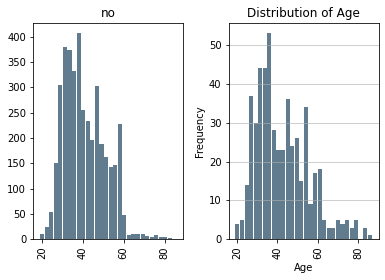

In [ ]:
size, scale = 1000, 10
df.hist(column='age',grid=True, bins=30, rwidth=0.9, color='#607c8e',by = 'y')

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [ ]:
cross_tab(df,'job','education')

,primary,secondary,tertiary,unknown
job,,,,
admin.,17,393,51,17
blue-collar,369,524,12,41
entrepreneur,26,58,73,11
housemaid,57,28,22,5
management,39,116,787,27
retired,80,106,32,16
self-employed,15,76,88,4
services,25,363,16,13
student,2,47,19,16


Inferring jobs from education : If 'education' = 'primary' or  or 'secondary' then the 'job' is usually 'blue-collar'. If 'education' = 'tertiary', then the 'job' = 'management'.

In [ ]:
#assumptions - on the basis of given education we can find the job for those which are unknown
df.loc[(df['job'] == 'unknown') & (df['education']=='primary'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='secondary'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='tertiary'), 'job'] = 'management'
df.loc[(df['job'] == 'unknown') & (df['education']=='unknown'), 'job'] = 'blue-collar'

cross_tab(df,'job','education')

,primary,secondary,tertiary,unknown
job,,,,
admin.,17,393,51,17
blue-collar,376,531,12,54
entrepreneur,26,58,73,11
housemaid,57,28,22,5
management,39,116,794,27
retired,80,106,32,16
self-employed,15,76,88,4
services,25,363,16,13
student,2,47,19,16


Inferring education from jobs : From the cross-tabulation, it can be seen that people with management jobs usually have a university degree. Hence wherever 'job' = management and 'education' = unknown, we can replace 'education' with 'tertiary'. Similarly, 'job' = 'services' --> 'education' = 'secondary' and 'job' = 'housemaid' --> 'education' = 'primary'. We do this for all the job categories where education is not known.


In [ ]:
#assumptions - on the basis of given job we can find the education for those which are unknown
df.loc[(df['education']=='unknown') & (df['job']=='admin.'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='blue-collar'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='entrepreneur'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'primary'
df.loc[(df['education']=='unknown') & (df['job']=='retired'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='self-employed'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='student'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='technician'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='unemployed'), 'education'] = 'secondary'

cross_tab(df,'job','education')

,primary,secondary,tertiary
job,,,
admin.,17,410,51
blue-collar,376,585,12
entrepreneur,26,58,84
housemaid,62,28,22
management,39,116,821
retired,80,122,32
self-employed,15,76,92
services,25,376,16
student,2,63,19


In [ ]:
df

,age,job,marital,education,default,balance,housing,loan,y
0,30,unemployed,married,primary,no,1787,no,no,no
1,33,services,married,secondary,no,4789,yes,yes,no
2,35,management,single,tertiary,no,1350,yes,no,no
3,30,management,married,tertiary,no,1476,yes,yes,no
4,59,blue-collar,married,secondary,no,0,yes,no,no
...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,no
4518,57,technician,married,secondary,no,295,no,no,no
4519,28,blue-collar,married,secondary,no,1137,no,no,no


## EDA

In [ ]:
# %matplotlib inline
# pd.crosstab(df.y,df.age).plot(kind='bar')
# plt.title('Age and Term Deposit')
# plt.xlabel('Term Deposit')
# plt.ylabel('Age Bracket')

Text(0, 0.5, 'Marital Deposit')

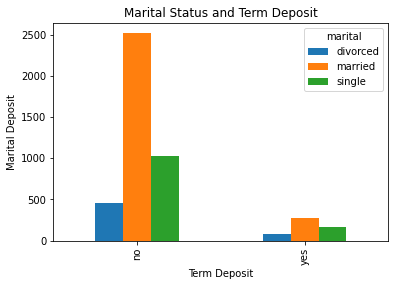

In [ ]:
%matplotlib inline
pd.crosstab(df.y,df.marital).plot(kind='bar')
plt.title('Marital Status and Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Marital Deposit')

Text(0, 0.5, 'Education')

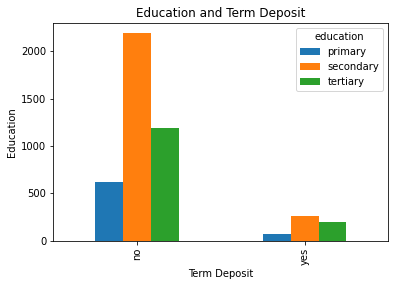

In [ ]:
%matplotlib inline
pd.crosstab(df.y,df.education).plot(kind='bar')
plt.title('Education and Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Education')

Text(0, 0.5, 'Housing Loan')

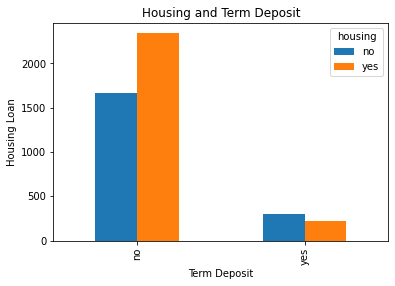

In [ ]:
%matplotlib inline
pd.crosstab(df.y,df.housing).plot(kind='bar')
plt.title('Housing and Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Housing Loan')

Text(0, 0.5, 'Personal Loan')

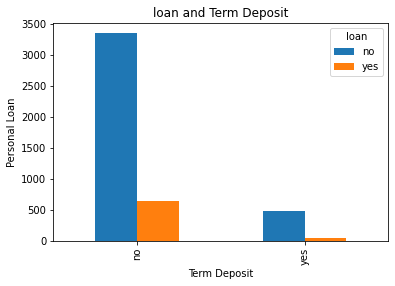

In [ ]:
%matplotlib inline
pd.crosstab(df.y,df.loan).plot(kind='bar')
plt.title('loan and Term Deposit')
plt.xlabel('Term Deposit')
plt.ylabel('Personal Loan')

## Feature Selection for Categorical feature & Cat. Target - Chi Sqaure

The chi2_contingency() function of scipy.stats module takes as input, the contingency table in 2d array format. It returns a tuple containing test statistics, the p-value, degrees of freedom and expected table(the one we created from the calculated values) in that order. 

Hence, we need to compare the obtained p-value with alpha value of 0.05.


H0 (Null Hypothesis) = The 2 variables to be compared are independent.

H1 (Alternate Hypothesis) = The 2 variables are dependent

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'y'],
      dtype='object')

In [ ]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
y            object
dtype: object

In [ ]:
# df = df.astype({"age":'object'})

We need to do the label encoding for running the chi square test

In [ ]:
# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
df_chi = df.copy()
# Encode labels in column 'age'. 
df_chi['age']= label_encoder.fit_transform(df_chi['age']) 
print(df_chi.head())

   age          job  marital  education default  balance housing loan   y
0   11   unemployed  married    primary      no     1787      no   no  no
1   14     services  married  secondary      no     4789     yes  yes  no
2   16   management   single   tertiary      no     1350     yes   no  no
3   11   management  married   tertiary      no     1476     yes  yes  no
4   40  blue-collar  married  secondary      no        0     yes   no  no


In [ ]:
df_chi['job']= label_encoder.fit_transform(df_chi['job']) 
df_chi['marital']= label_encoder.fit_transform(df_chi['marital']) 
df_chi['education']= label_encoder.fit_transform(df_chi['education']) 
df_chi['default']= label_encoder.fit_transform(df_chi['default']) 
df_chi['housing']= label_encoder.fit_transform(df_chi['housing'])
df_chi['loan']= label_encoder.fit_transform(df_chi['loan'])
df_chi['y']= label_encoder.fit_transform(df_chi['y'])

print(df_chi.head())

   age  job  marital  education  default  balance  housing  loan  y
0   11   10        1          0        0     1787        0     0  0
1   14    7        1          1        0     4789        1     1  0
2   16    4        2          2        0     1350        1     0  0
3   11    4        1          2        0     1476        1     1  0
4   40    1        1          1        0        0        1     0  0


In [ ]:
df_chi.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'y'],
      dtype='object')

Feature 0: 11.679248
Feature 1: 0.248626
Feature 2: 3.339391
Feature 3: 0.039239
Feature 4: 11.788867
Feature 5: 12.889637


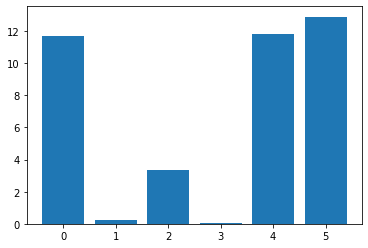

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot
 
X = df_chi.drop(['y','age','balance'],axis=1)
y = df_chi['y']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data


# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [ ]:
X.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')

## Feature Selection for categorical target & Numerical feature - ANNOVA

In [ ]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# generate dataset
X = df_chi[['age','balance']]
y = df_chi['y']
# define feature selection
fs = SelectKBest(score_func=f_classif, k=2)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(4521, 2)


Feature 0: 9.115066
Feature 1: 1.449222


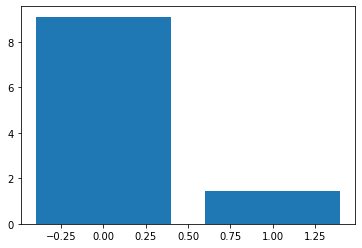

In [ ]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Data PreProcessing for categorical columns

Final Columns - Job, Education, Housing, Loan, Age

In [ ]:
df_final = df.copy()
df_final

,age,job,marital,education,default,balance,housing,loan,y
0,30,unemployed,married,primary,no,1787,no,no,no
1,33,services,married,secondary,no,4789,yes,yes,no
2,35,management,single,tertiary,no,1350,yes,no,no
3,30,management,married,tertiary,no,1476,yes,yes,no
4,59,blue-collar,married,secondary,no,0,yes,no,no
...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,no
4518,57,technician,married,secondary,no,295,no,no,no
4519,28,blue-collar,married,secondary,no,1137,no,no,no


In [ ]:
df_final.loc[df_final["job"] == "student", "job"] = 'unemployed'

In [ ]:
df_final.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'y'],
      dtype='object')

In [ ]:
# for lst in df_final.columns:
#   print(df_final[lst].value_counts())
#   print('===================================================================')

In [ ]:
df_final = df_final[['age', 'job', 'education', 'housing','loan', 'y']]
df_final

,age,job,education,housing,loan,y
0,30,unemployed,primary,no,no,no
1,33,services,secondary,yes,yes,no
2,35,management,tertiary,yes,no,no
3,30,management,tertiary,yes,yes,no
4,59,blue-collar,secondary,yes,no,no
...,...,...,...,...,...,...
4516,33,services,secondary,yes,no,no
4517,57,self-employed,tertiary,yes,yes,no
4518,57,technician,secondary,no,no,no
4519,28,blue-collar,secondary,no,no,no


In [ ]:
df_final['job']= label_encoder.fit_transform(df_final['job']) 
df_final['education']= label_encoder.fit_transform(df_final['education']) 
df_final['housing']= label_encoder.fit_transform(df_final['housing']) 
df_final['loan']= label_encoder.fit_transform(df_final['loan']) 
df_final['y']= label_encoder.fit_transform(df_final['y']) 

In [ ]:
df_final

,age,job,education,housing,loan,y
0,30,9,0,0,0,0
1,33,7,1,1,1,0
2,35,4,2,1,0,0
3,30,4,2,1,1,0
4,59,1,1,1,0,0
...,...,...,...,...,...,...
4516,33,7,1,1,0,0
4517,57,6,2,1,1,0
4518,57,8,1,0,0,0
4519,28,1,1,0,0,0


In [ ]:

df_cat = pd.get_dummies(df[['job', 'education', 'housing','loan', 'y']])
df_cat

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,y_no,y_yes
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0
4517,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0
4518,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0
4519,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0


**Drop one of the dummy variables as for n categories we only need n-1 dummy variables.**

In [ ]:
features_dropped = ['housing_no','loan_no','y_no','education_primary','job_unemployed']
df_cat.drop(features_dropped, axis=1, inplace=True)

In [ ]:
df_cat.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'education_secondary',
       'education_tertiary', 'housing_yes', 'loan_yes', 'y_yes'],
      dtype='object')

In [ ]:
# type(df_final['age'])

final_df = df_cat.assign(age = df_final['age'])
final_df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,education_secondary,education_tertiary,housing_yes,loan_yes,y_yes,age
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30
1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,33
2,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,35
3,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,30
4,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,33
4517,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,57
4518,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,57
4519,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,28


In [ ]:

# Check the output percentage of the data
# print(final_df['y_yes'].value_counts())
# print('People who took term deposit(Class 1): ', round(final_df['y_yes'].value_counts()[1]/len(df) * 100,1), '% of whole data set')
# print('People who didnot took term deposit(Class 0): ', round(df_final['y_yes'].value_counts()[0]/len(df) * 100,1), '% of whole data set')


# Significant Variables

In [ ]:
final_df.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'education_secondary',
       'education_tertiary', 'housing_yes', 'loan_yes', 'y_yes', 'age'],
      dtype='object')

In [ ]:
final_df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,education_secondary,education_tertiary,housing_yes,loan_yes,y_yes,age
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30
1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,33
2,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,35
3,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,30
4,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,33
4517,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,57
4518,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,57
4519,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,28


In [ ]:
# Creating X and y
X1 = final_df[['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'education_secondary',
       'education_tertiary', 'housing_yes', 'loan_yes', 'age']]
y1 = final_df[['y_yes']]

# Splitting the varaibles as training and testing
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size = 0.8, 
                                                    test_size = 0.2, random_state = 100)

# Importing Statsmodels.api library from Stamodel package
import statsmodels.api as sm

# Adding a constant to get an intercept
X_train_sm = sm.add_constant(X_train1)

# Fitting the resgression line using 'OLS'
lr = sm.OLS(y_train1, X_train_sm).fit()

# Printing the parameters
# print(lr.params)

# Performing a summary to list out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_yes   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.008
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           2.48e-15
Time:                        04:53:34   Log-Likelihood:                -985.48
No. Observations:                3616   AIC:                             2003.
Df Residuals:                    3600   BIC:                             2102.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0977    

# Logistic Regression Model - Selected Significant Features

In [ ]:
#Significant columns

df_end = final_df[['job_retired','job_student','education_secondary', 'education_tertiary', 'housing_yes', 'loan_yes', 'y_yes']]

X=df_end.loc[:, df_end.columns != 'y_yes']
y=df_end.y_yes


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Confusion Matrix, Accuracy & ROC

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_train = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.5f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))
# print(f1_score(y_test,y_pred))

Train/Test split results:
LogisticRegression accuracy is 0.87624
LogisticRegression log_loss is 0.371
LogisticRegression auc is 0.610


In [ ]:
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,All
Actual,,
0,793,793
1,112,112
All,905,905


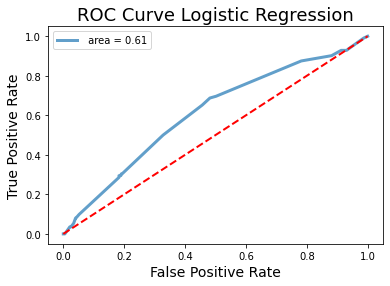

In [ ]:
#ROC curve

# Draw the roc-curve
logis_fpr, logis_tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc_logis= auc(logis_fpr,logis_tpr)
plt.plot(logis_fpr,logis_tpr, label = " area = {:0.2f}".format(roc_auc_logis), lw = 3, alpha = 0.7)
plt.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
plt.xlabel("False Positive Rate", fontsize = 14)
plt.ylabel("True Positive Rate", fontsize = 14)
plt.title("ROC Curve Logistic Regression", fontsize = 18)
plt.legend(loc = 'best')

Set the threshold to below 0.5 - unbalanced class

In [ ]:
# threshold = []
# accuracy = []

# for p in np.unique(logreg.predict_proba(X_train)[:,1]):
#   threshold.append(p)
#   y_pred = (logreg.predict_proba(X_train)[:,1] >= p).astype(int)
#   accuracy.append(balanced_accuracy_score(y_train,y_pred))

## Feature Importance for LR

In [ ]:
type(logreg.coef_[0])

numpy.ndarray

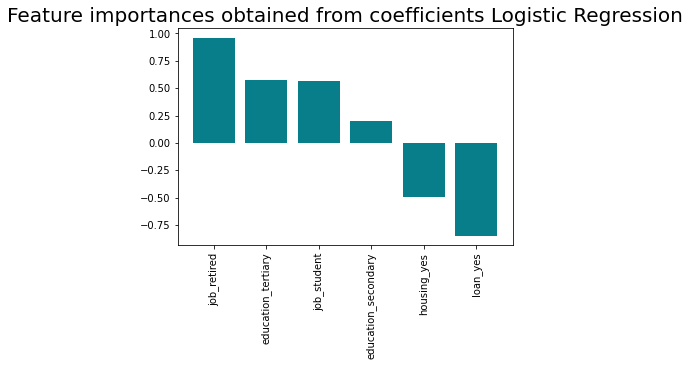

In [ ]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients Logistic Regression', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# # get importance
# importance = logreg.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# Ada Boost Classifier Model

https://www.datacamp.com/community/tutorials/adaboost-classifier-python

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# all the Training & Test datasets remain the same

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model_ada = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_ada = model_ada.predict(X_test)

#Predict class probabilities of input validation data
adplot=model_ada.predict_proba(X_test)

adpre=adplot[:,1]
    
#Computation to compute AUC score
# calculate the fpr and tpr for all thresholds of the classification
adfpr, adtpr, adthresholds=metrics.roc_curve(y_test,adpre)
roc_auc = metrics.roc_auc_score(y_test,adpre)

#Feature importances. The higher the score, the more important the feature.
feature_imp = model_ada.feature_importances_


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_ada))

Accuracy: 0.876243093922652


### Confusion Matric, Accuracy & ROC

In [ ]:
confusion_matrix(y_test,y_pred_ada)
pd.crosstab(y_test, y_pred_ada, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,All
Actual,,
0,793,793
1,112,112
All,905,905


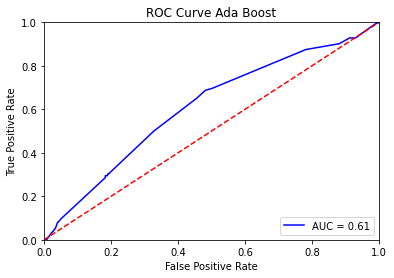

In [ ]:

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve Ada Boost')
plt.plot(adfpr, adtpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Importance - Ada Boost

In [ ]:
feature_imp

array([0.14, 0.08, 0.3 , 0.32, 0.1 , 0.06])

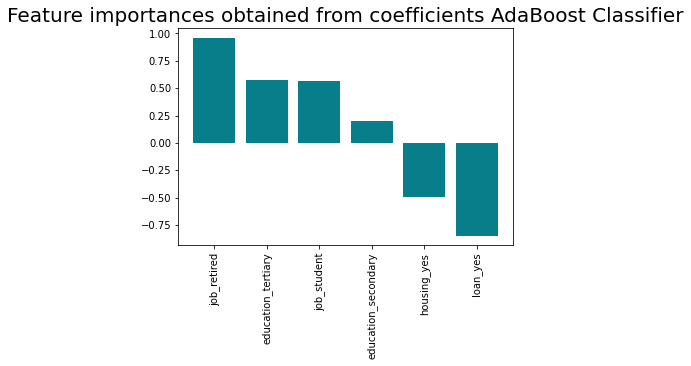

In [ ]:
importances_ada = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': feature_imp
})
importances_ada = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances_ada['Attribute'], height=importances_ada['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients AdaBoost Classifier', size=20)
plt.xticks(rotation='vertical')
plt.show()

We can further improve the accuracy with Hyperparamter tuning and having another classifier - default classifier in Ada Boost is Decision tree

# RandomForest Model

In [ ]:
# random forest for feature importance on a classification 

# define the model
model_RF = RandomForestClassifier()
# fit the model
model_RF.fit(X_train, y_train)
# get importance
importance_RF = model_RF.feature_importances_


### Confusion Matrix, Accuracy & ROC

In [ ]:
y_pred_RF = model_RF.predict(X_test)

y_pred_probaR = model_RF.predict_proba(X_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_probaR)

print('Train/Test split results:')
print(" accuracy is %2.5f" % accuracy_score(y_test, y_pred_RF))
# print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_probaR))
print(" auc is %2.3f" % auc(fpr1, tpr1))



Train/Test split results:
 accuracy is 0.86961
 auc is 0.598


In [ ]:
confusion_matrix(y_test,y_pred_RF)
pd.crosstab(y_test, y_pred_RF, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,786,7,793
1,111,1,112
All,897,8,905


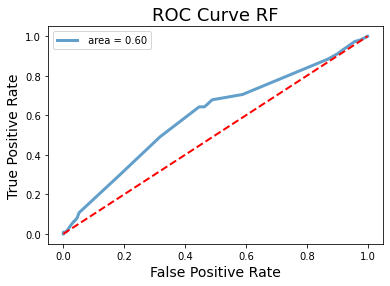

In [ ]:
#ROC curve

# Draw the roc-curve

RF_fpr, RF_tpr, thresholds_roc = roc_curve(y_test,y_pred_probaR)
# logis_fpr, logis_tpr, thresholds_roc = roc_curve(y_test, y_pred_probaR[:,1],drop_intermediate=False)
roc_auc_RF= auc(RF_fpr,RF_tpr)
plt.plot(RF_fpr,RF_tpr, label = " area = {:0.2f}".format(roc_auc_RF), lw = 3, alpha = 0.7)
plt.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
plt.xlabel("False Positive Rate", fontsize = 14)
plt.ylabel("True Positive Rate", fontsize = 14)
plt.title("ROC Curve RF", fontsize = 18)
plt.legend(loc = 'best')

### Feature Importance of RF

In [ ]:
importance_RF

array([0.23853304, 0.09570887, 0.08072312, 0.16878934, 0.21639874,
       0.19984688])

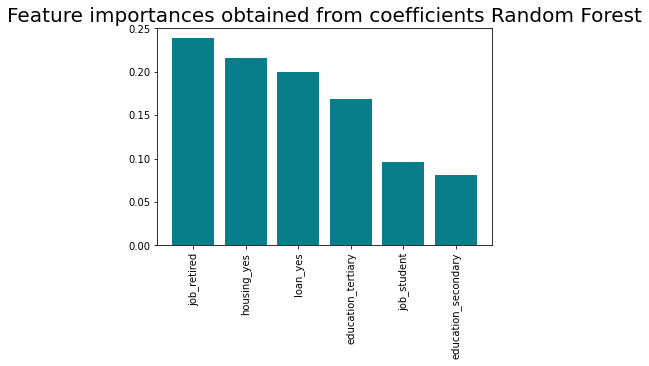

In [ ]:
importancesR = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': importance_RF
})
importancesR = importancesR.sort_values(by='Importance', ascending=False)

plt.bar(x=importancesR['Attribute'], height=importancesR['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients Random Forest', size=20)
plt.xticks(rotation='vertical')
plt.show()


# # summarize feature importance
# for i,v in enumerate(importance_RF):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance_RF))], importance_RF)
# plt.show()